In this notebook we will use a grid of voxels along with its respective occupancy to build a vector that will serve as a global feature for representing the 3D data.

In [1]:
import h5py
import os
import numpy as np
from IPython.display import Image
from voxelgrid import VoxelGrid
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.cmap'] = 'gray'

## Read data from HDF5 file

In [3]:
TRAIN_PATH = "../train_point_clouds.h5"

In [19]:
TEST_PATH = "../test_point_clouds.h5"

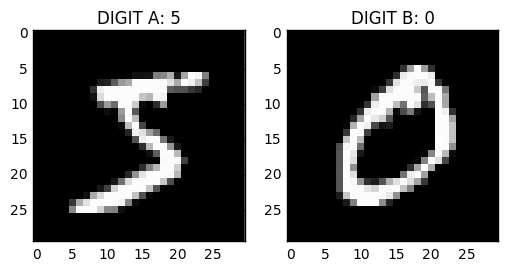

In [5]:
with h5py.File(TRAIN_PATH, "r") as hf:    

    a = hf["0"]
    b = hf["1"]
    
    digit_a = (a["img"][:], a["points"][:], a.attrs["label"]) 
    digit_b = (b["img"][:], b["points"][:], b.attrs["label"]) 

plt.subplot(121)
plt.title("DIGIT A: " + str(digit_a[2]))
plt.imshow(digit_a[0])

plt.subplot(122)
plt.title("DIGIT B: " + str(digit_b[2]))
plt.imshow(digit_b[0])

## Generate VoxelGrid

![VoxelGrid](./data/voxelgrid.png)

The VoxelGrid will fit an axis-aligned bounding box around the point cloud and then subdivide the box in segments along each corresponding axis.

The x_y_z argument indicates how many segments we want per axis.

We will split each axis in 8 voxels wich would be equivalent to use the 3th level of an Octree.

This will generate a total of 512 different voxels.

In [6]:
a_voxelgrid = VoxelGrid(digit_a[1], x_y_z=[8, 8, 8])
b_voxelgrid = VoxelGrid(digit_b[1], x_y_z=[8, 8, 8])

This will generate an object with several attributes.

In the structure attribute we can find a 2D array where each row represents a point in the original point cloud and each column represents the n_voxel where it lies with respect to [x_axis, y_axis, z_axis, global].

In [7]:
# point coordinates
digit_a[1][340]

array([ 0.13965517, -0.1094358 ,  0.47305447])

In [8]:
# n_voxel
a_voxelgrid.structure[340]

array([  5,   3,   7, 477])

In [9]:
digit_b[1][5200]

array([ 0.05689655,  0.37270992,  0.32146947])

In [10]:
b_voxelgrid.structure[5200]

array([  4,   6,   6, 436])

## Visualize the VoxelGrid.structure

In [11]:
def plot_colorfull_hist(array):
    cm = plt.cm.get_cmap('gist_rainbow')
    n, bins, patches = plt.hist(array, bins=64)

    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
    plt.show()

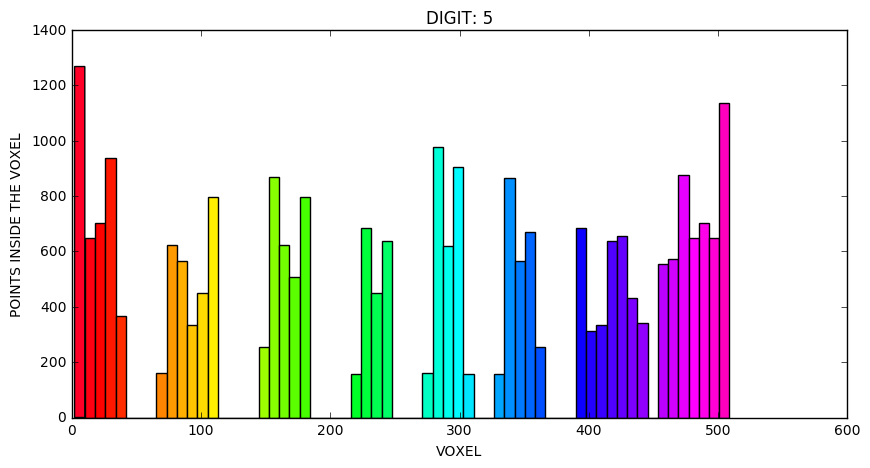

In [12]:
plt.figure(figsize=(10,5))
plt.title("DIGIT: " + str(digit_a[-1]))
plt.xlabel("VOXEL")
plt.ylabel("POINTS INSIDE THE VOXEL")
plot_colorfull_hist(a_voxelgrid.structure[:,-1])

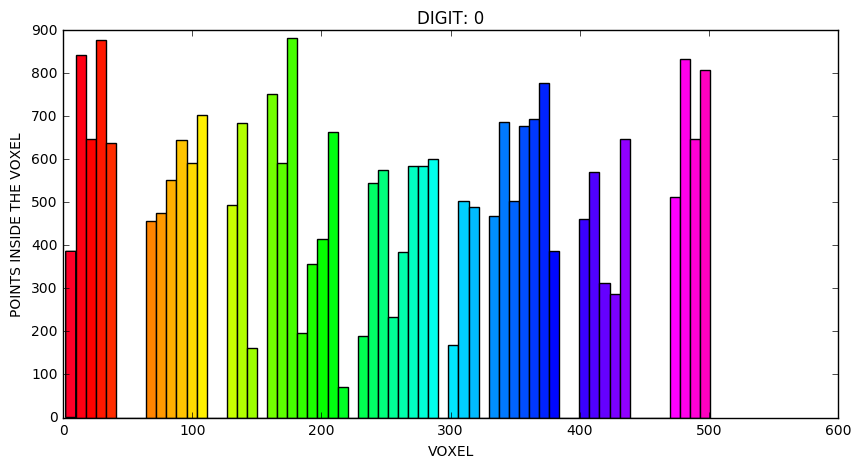

In [13]:
plt.figure(figsize=(10,5))
plt.title("DIGIT: " + str(digit_b[-1]))
plt.xlabel("VOXEL")
plt.ylabel("POINTS INSIDE THE VOXEL")
plot_colorfull_hist(b_voxelgrid.structure[:,-1])

As we can see in the histograms there is a lot of empty voxels. 

This is due to the use of a cuboid bounding box to ensure that the VoxelGrid will divide the cloud in a similar way even when the point clouds are oriented to different directions.

We can use the built-in function plot() to visualize the voxelgrid.

The function will display the voxelgrid sliced around the z-axis.

You might need a nice spatial vision capacity to visualize the point cloud.

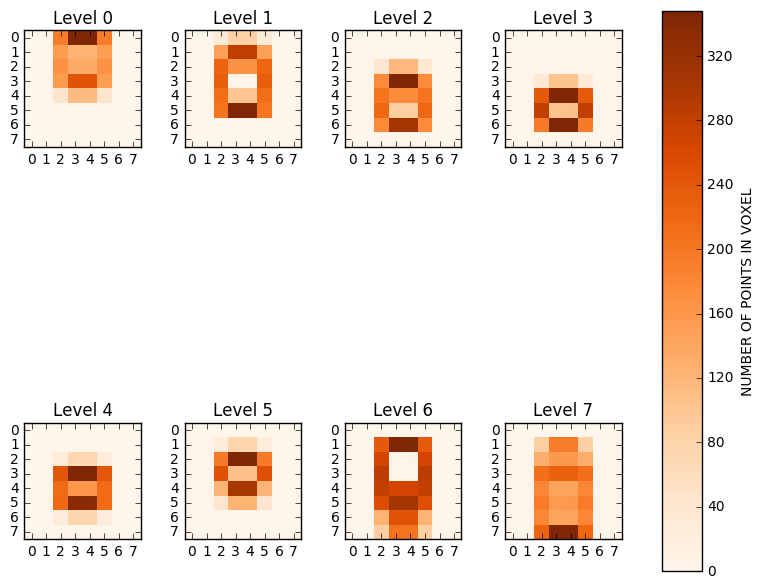

In [14]:
a_voxelgrid.plot()

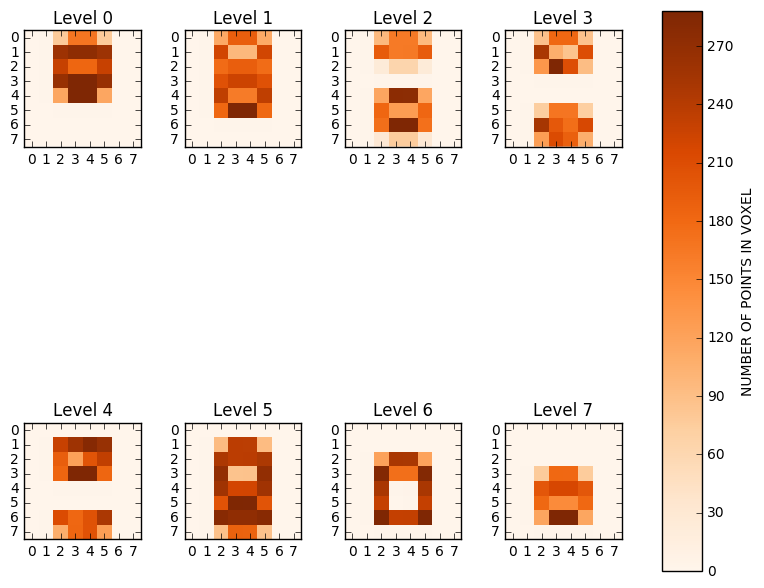

In [15]:
b_voxelgrid.plot()

Or even better we can save the voxelgrid's structure as scalar fields of the original point cloud and visualize it in any 3D software that supports point clouds and scalar fields (I like CloudCompare).

In [16]:
# Uncomment if you run this locally
#cloud_a = np.concatenate((digit_a[1], a_voxelgrid.structure), axis=1)
#cloud_b = np.concatenate((digit_b[1], b_voxelgrid.structure), axis=1)

#np.savetxt("data/"+ str(digit_a[2]) + ".txt", cloud_a)
#np.savetxt("data/"+ str(digit_b[2]) + ".txt", cloud_b)

## Associate voxel along X axis

![0_X](./data/0_X.png)

## Associate voxel along Y axis

![0_Y](./data/0_Y.png)

## Associate voxel along Z axis

![0_Z](./data/0_Z.png)

## Global associate voxel

![0_N](./data/0_N.png)

![5_N](./data/5_N.png)

## Generate the global feature vector for all the dataset

As we see in the picture the voxel global is the feature that contains information about all the 3 axis combined.

The voxel global count is stored in the voxelgrid.vector attribute.

This vector holds the count of points that lie inside each of the global voxels.

In [17]:
a_voxelgrid.vector

array([[[   0.,    0.,  226.,  408.,  408.,  226.,    0.,    0.],
        [   0.,    0.,  180.,  144.,  144.,  180.,    0.,    0.],
        [   0.,    0.,  195.,  156.,  156.,  195.,    0.,    0.],
        [   0.,    0.,  180.,  288.,  288.,  180.,    0.,    0.],
        [   0.,    0.,   51.,  132.,  132.,   51.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]],

       [[   0.,    0.,   21.,   60.,   60.,   21.,    0.,    0.],
        [   0.,    0.,  107.,  204.,  204.,  107.,    0.,    0.],
        [   0.,    0.,  162.,  120.,  120.,  162.,    0.,    0.],
        [   0.,    0.,  168.,    0.,    0.,  168.,    0.,    0.],
        [   0.,    0.,  153.,   72.,   72.,  153.,    0.,    0.],
        [   0.,    0.,  146.,  252.,  252.,  146.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        

We can use the voxelgrid.vector as a global feature for representing the 3D digits.

## Generate the vector for all the dataset

Iterate over each HDF5 file to generate the array of vectors

### Train

In [18]:
with h5py.File(TRAIN_PATH, "r") as hf:
    size = len(hf.keys())
    # tuple to store the vectors and labels
    out = (np.zeros((size, 512), dtype=np.float16), np.zeros(size, dtype=np.int8))
    
    for i in range(size):
        if i % 200 == 0:
            print(i, "\t processed")
        voxelgrid = VoxelGrid(hf[str(i)]["points"][:], x_y_z=[8, 8, 8])
        # make the vector range 0-1
        out[0][i] = voxelgrid.vector.reshape(-1) / np.max(voxelgrid.vector)
        out[1][i] = hf[str(i)].attrs["label"]
    print("[DONE]")
    X_train, y_train = out

0 	 processed
200 	 processed
400 	 processed
600 	 processed
800 	 processed
1000 	 processed
1200 	 processed
1400 	 processed
1600 	 processed
1800 	 processed
2000 	 processed
2200 	 processed
2400 	 processed
2600 	 processed
2800 	 processed
3000 	 processed
3200 	 processed
3400 	 processed
3600 	 processed
3800 	 processed
4000 	 processed
4200 	 processed
4400 	 processed
4600 	 processed
4800 	 processed
[DONE]


In [21]:
with h5py.File(TEST_PATH, "r") as hf:
    size = len(hf.keys())
    # tuple to store the vectors and labels
    out = (np.zeros((size, 512), dtype=np.float16), np.zeros(size, dtype=np.int8))
    
    for i in range(size):
        if i % 200 == 0:
            print(i, "\t processed")
        voxelgrid = VoxelGrid(hf[str(i)]["points"][:], x_y_z=[8, 8, 8])
        # make the vector range 0-1
        out[0][i] = voxelgrid.vector.reshape(-1) / np.max(voxelgrid.vector)
        out[1][i] = hf[str(i)].attrs["label"]
    print("[DONE]")
    X_valid, y_valid = out

0 	 processed
200 	 processed
400 	 processed
600 	 processed
800 	 processed
[DONE]


## Save the new features

In [22]:
# Uncomment if you run this locally

#np.savez_compressed("voxelgrid.npz", X_train=train_set[0], y_train=train_set[1],
#                    X_test=test_set[0], y_test=test_set[1], X_valid=valid_set[0],
#                    y_valid=valid_set[1])

## Train a simple linear model

In [23]:
from sklearn.svm import LinearSVC

In [24]:
clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Validation Score

In [25]:
print("Validation Score: ", clf.score(X_valid, y_valid))

Validation Score:  0.896


As we can see we get a relatively decent score for our first work with 3D data. However we must take in account that the data has been manually oriented and refined to make the problem simplier. 

Check the kernell "Data augmentation" to learn how to generate a more realistic dataset from the original 3DMNIST with noise and random orientations.

## Get the misclassified images and plot a sample

In [26]:
y_pred = clf.predict(X_valid)
miss = np.where(y_pred != y_valid)[0]

In [27]:
# load images from HDF5 dataset
with h5py.File(TEST_PATH, "r") as hf:
    wrong_pred = []
    for i in miss:
        wrong_pred.append((hf[str(i)]["img"][:], y_pred[i], y_valid[i]))

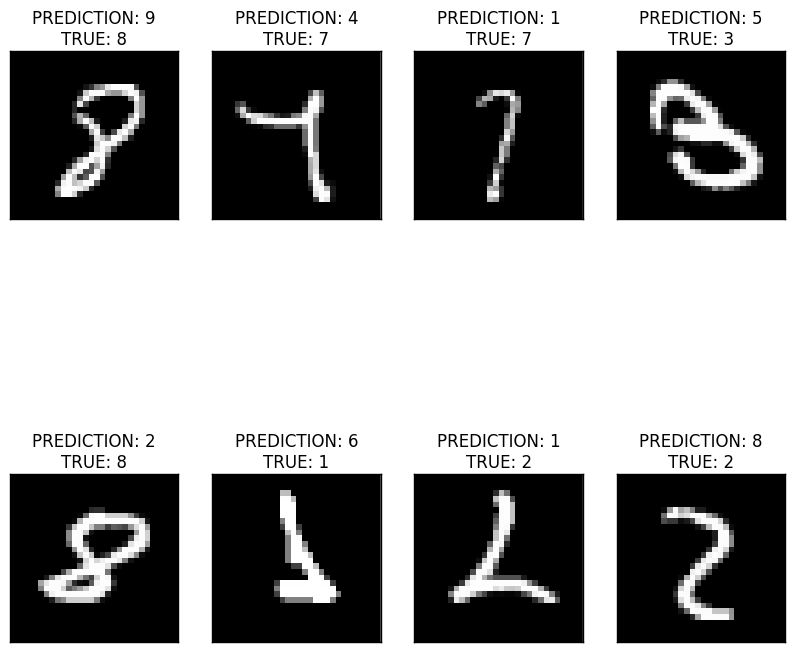

In [28]:
fig, axes = plt.subplots(2, 4, figsize=(10,10))

random_idx = np.random.randint(0, len(wrong_pred), 8)

for i, ax in enumerate(axes.flat):
    ax.imshow(wrong_pred[random_idx[i]][0])
    ax.set_title("PREDICTION: "+ str(wrong_pred[random_idx[i]][1]) + "\n" +
                "TRUE: " + str(wrong_pred[random_idx[i]][2]))
    ax.set_xticks([])
    ax.set_yticks([])

## Confusion Matrix

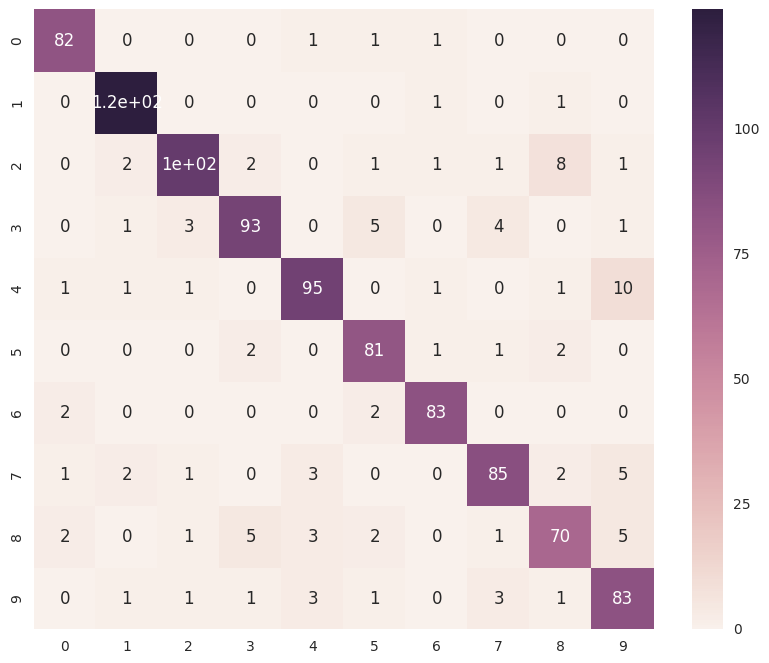

In [29]:
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_valid, y_pred)
df_cm = pd.DataFrame(array, index = range(10),
                  columns = range(10))
plt.figure(figsize=(10,8))
sn.heatmap(df_cm, annot=True)